In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [1]:
#brew install graphviz
#!pip install torchviz

In [2]:
'''# Example dataset dimensions
num_time_steps = 1000     # Number of time steps
num_altitudes = 50        # Number of altitude levels
num_latitudes = 200       # Latitude grid size
num_longitudes = 200      # Longitude grid size
# Create a synthetic dataset (replace with actual data)
reflectivity_grid = np.random.rand(num_time_steps, num_altitudes, num_latitudes, num_longitudes).astype(np.float32)
rainfall_grid = np.random.rand(num_time_steps, num_latitudes, num_longitudes).astype(np.float32)'''

In [28]:
radar_ros = np.load('radar_data_sorted.npy', allow_pickle=True)
rain_ros = np.load('rain_data_ros.npy', allow_pickle=True)


In [30]:
num_time_steps = 3        # Number of time steps (3 in radar_ros)
num_latitudes = 2815      # Latitude/longitude grid size
num_altitudes = 40  

In [31]:
X = torch.tensor(radar_ros,dtype=torch.float32).unsqueeze(1)   # Shape: (channels, time_steps, altitudes)
y = torch.tensor(rain_ros,dtype=torch.float32)   # Shape: (channels, time_steps)
# Create TensorDataset and DataLoader
# Create TensorDataset and DataLoader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [35]:
'''# Multi-GPU support (if available)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_model = nn.DataParallel(cnn_model)'''

In [45]:
# CNN-LSTM model in PyTorch
class CNNLSTMModel(nn.Module):
    def __init__(self, num_latitudes, num_altitudes):
        super(CNNLSTMModel, self).__init__()
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(1, 3, 3), padding='same')  # 1 time step, spatial kernel
        self.pool3d_1 = nn.MaxPool3d(kernel_size=(1, 2, 2))  # No downsampling on altitude axis
        self.conv3d_2 = nn.Conv3d(32, 64, kernel_size=(1, 3, 3), padding='same')
        self.pool3d_2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.conv3d_3 = nn.Conv3d(64, 128, kernel_size=(1, 3, 3), padding='same')
        self.pool3d_3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        # Calculate the size after convolution and pooling layers
        # We need to account for the dimensions after each conv/pool layer
        self.flatten_size = (num_latitudes // 8) * (num_altitudes // 8) * 128  # Adjust based on pooling layers

        self.lstm = nn.LSTM(input_size=self.flatten_size, hidden_size=512, batch_first=True)
        self.fc = nn.Linear(512, num_latitudes)
        self.reshape_output = nn.Unflatten(dim=1, unflattened_size=(num_latitudes,))

    def forward(self, x):
        batch_size, time_steps = x.shape[:2]
        # Reshape input for TimeDistributed Conv3D
        x = x.view(-1, 1, *x.shape[2:])  # Merge batch and time dimension, add channel dim
        
        # TimeDistributed Conv3D + MaxPool3D layers
        x = self.pool3d_1(torch.relu(self.conv3d_1(x)))
        x = self.pool3d_2(torch.relu(self.conv3d_2(x)))
        x = self.pool3d_3(torch.relu(self.conv3d_3(x)))

        # Flatten and reshape back to (batch_size, time_steps, features)
        x = x.view(batch_size, time_steps, -1)  # Get the output size here correctly
        # LSTM layer
        x, _ = self.lstm(x)
        # Fully connected layer and reshape to (latitudes)
        x = torch.relu(self.fc(x[:, -1, :]))  # Use the last LSTM output for prediction
        x = self.reshape_output(x)
        return x

# Model initialization
input_shape = (num_time_steps, num_latitudes, num_altitudes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNNLSTMModel(num_latitudes, num_altitudes).to(device)

# Optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
#loss_fn = nn.MSELoss()
# RMSE loss function
def rmse_loss(outputs, targets):
    return torch.sqrt(torch.mean((outputs - targets) ** 2))

import matplotlib.pyplot as plt

# Training Loop
def train_model(model, train_loader, optimizer, loss_fn, device, epochs=10):
    model.train()
    train_losses = []  # Store training losses
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)  # Append epoch loss
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f}")
    return train_losses  # Return training losses

# Testing Loop
def test_model(model, test_loader, loss_fn, device,epochs=10):
    model.eval()
    test_losses = []  # Store testing losses
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)
            test_loss += loss.item()
    average_test_loss = test_loss / len(test_loader)
    test_losses.append(average_test_loss)  # Append test loss
    print(f"Test Loss: {average_test_loss:.4f}")
    return test_losses  # Return testing losses


# Train and test the model
#train_model(cnn_model, train_loader, optimizer, loss_fn, device, epochs=10)

In [40]:
#test_model(cnn_model, test_loader, loss_fn, device)


Test Loss: 472.7301


Epoch [1/20] Loss: 12.6903
Epoch [2/20] Loss: 12.6795
Epoch [3/20] Loss: 12.6687
Epoch [4/20] Loss: 12.6614
Epoch [5/20] Loss: 12.6577
Epoch [6/20] Loss: 12.6556
Epoch [7/20] Loss: 12.6502
Epoch [8/20] Loss: 12.6434
Epoch [9/20] Loss: 12.6405
Epoch [10/20] Loss: 12.6387
Epoch [11/20] Loss: 12.6352
Epoch [12/20] Loss: 12.6327
Epoch [13/20] Loss: 12.6315
Epoch [14/20] Loss: 12.6334
Epoch [15/20] Loss: 12.6413
Epoch [16/20] Loss: 12.6407
Epoch [17/20] Loss: 12.6401
Epoch [18/20] Loss: 12.6379
Epoch [19/20] Loss: 12.6342
Epoch [20/20] Loss: 12.6320
Test Loss: 12.6297


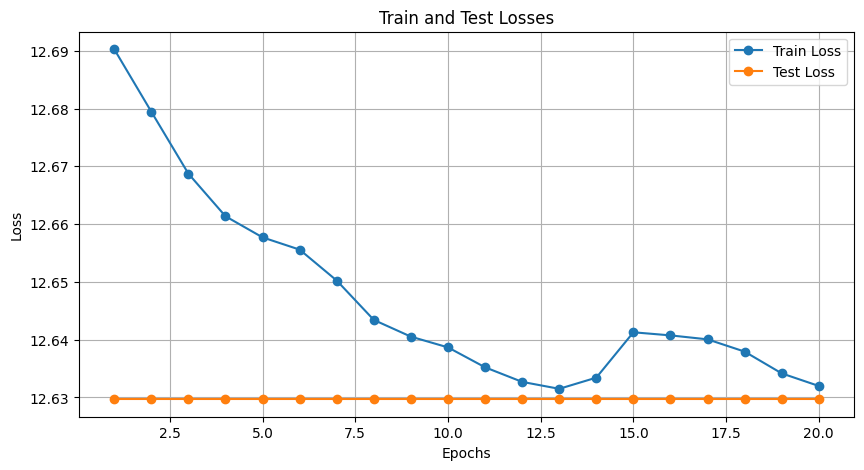

In [46]:
# Train and test the model
train_losses = train_model(cnn_model, train_loader, optimizer, loss_fn, device, epochs=20)
test_losses = test_model(cnn_model, test_loader, loss_fn, device,epochs=20)

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses * len(train_losses), label='Test Loss', marker='o')  # Repeat test loss for plotting
plt.title('Train and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch [1/10] - Train Loss (RMSE): 12.6314, Test Loss (RMSE): 12.6291
Epoch [2/10] - Train Loss (RMSE): 12.6305, Test Loss (RMSE): 12.6305
Epoch [3/10] - Train Loss (RMSE): 12.6314, Test Loss (RMSE): 12.6290
Epoch [4/10] - Train Loss (RMSE): 12.6280, Test Loss (RMSE): 12.6248
Epoch [5/10] - Train Loss (RMSE): 12.6246, Test Loss (RMSE): 12.6226
Epoch [6/10] - Train Loss (RMSE): 12.6225, Test Loss (RMSE): 12.6211
Epoch [7/10] - Train Loss (RMSE): 12.6210, Test Loss (RMSE): 12.6192
Epoch [8/10] - Train Loss (RMSE): 12.6191, Test Loss (RMSE): 12.6177
Epoch [9/10] - Train Loss (RMSE): 12.6177, Test Loss (RMSE): 12.6162
Epoch [10/10] - Train Loss (RMSE): 12.6166, Test Loss (RMSE): 12.6163


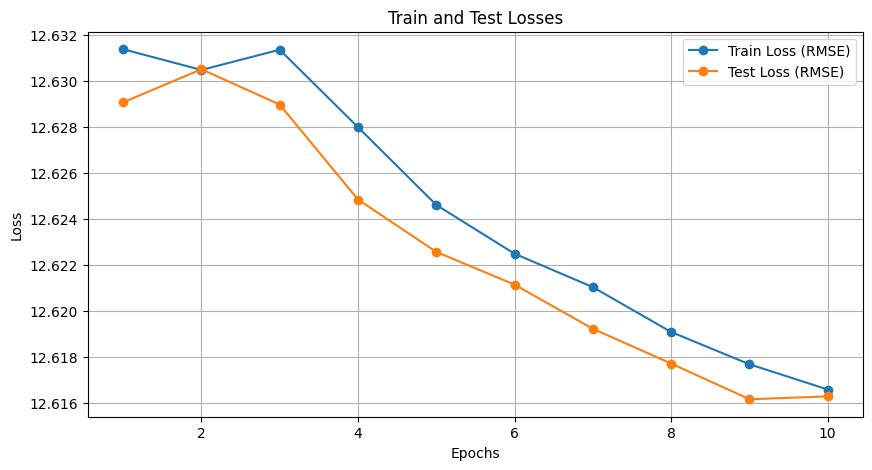

In [47]:
# Training and Testing Loop
def train_and_test_model(model, train_loader, test_loader, optimizer, device, epochs=10):
    model.train()
    all_train_losses = []  # Store training losses
    all_test_losses = []   # Store testing losses

    for epoch in range(epochs):
        running_train_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)  # Use RMSE loss
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Calculate average train loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        all_train_losses.append(avg_train_loss)

        # Test the model
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = rmse_loss(outputs, targets)  # Use RMSE loss
                running_test_loss += loss.item()

        # Calculate average test loss for the epoch
        avg_test_loss = running_test_loss / len(test_loader)
        all_test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss (RMSE): {avg_train_loss:.4f}, Test Loss (RMSE): {avg_test_loss:.4f}")

    return all_train_losses, all_test_losses  # Return training and testing losses

# Train and test the model
train_losses, test_losses = train_and_test_model(cnn_model, train_loader, test_loader, optimizer, device, epochs=10)

# Plotting the losses
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss (RMSE)', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss (RMSE)', marker='o')
plt.title('Train and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()